<a href="https://colab.research.google.com/github/rland93/pendsim/blob/master/notebooks/linearization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
GOOGLE_COLAB = True

In [13]:
if not GOOGLE_COLAB:
    %cd ../
else:
    !pip install pendsim

In [14]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML

# Linearization Notebook
This notebook explores linearization: what does it mean to linearize a non-linear system?

The inverted pendulum system has an equation of motion:
    
$$ (M+m)\ddot{x} - m l \ddot{\theta}\cos{\theta} + m l \dot{\theta} ^2 \sin{\theta} = u $$
$$ l \ddot{\theta} - g \sin{\theta} = \ddot{x} \cos{\theta}$$ 
    
This system is a 2nd-order system of differential equations in terms of $x$ and $\theta$. It is highly non-linear: we have several sines and cosines and some quadratic terms. The system in this form can be very difficult to deal with, especially if we want to do any kind of optimization over it (like in a linear quadratic regulator or model predictive controller). 

We can easily produce, however, a simplified, linear approximation of the system, that behaves similar to the system in the neighborhood around a given point.

To do so, we will use techniques familiar to us from calculus.

Let's take a non-linear function, $f(x) = 2 sin(x)$, as an example. This looks squiggly:

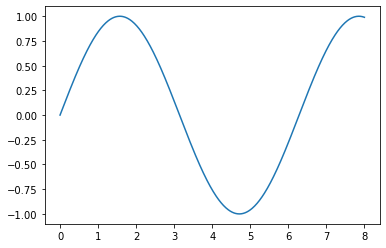

In [15]:
x = np.linspace(0,8,500)
y = np.sin(x)
plt.plot(x, y)

We know from calculus that we can take the derivative of this function and get its Taylor Series around any point $a$ that we want. Let's choose $x=1$.

To find the taylor series about $x=a=1$, we evaluate the function's derivative at the point of interest and use that to find the series terms:

$$f(a) + \frac{f'(a)}{1!} (x-a) + \frac{f''(a)}{2!} (x-a)^2 + \frac{f'''(a)}{3!} (x-a)^3 ... $$

Now, this series continues forever, and it's also non-linear. As we continue to add terms to the summation, the limit approaches our original function.

In [16]:
# helper function for drawing taylor series
def taylor_plot(a, x):
    a = 1
    y = np.sin(x)
    y1 = np.repeat(np.sin(a), y.shape)
    y2 = y1 + np.cos(a) * (x-a)
    y3 = y2 + np.sin(a) * (1/2.) * (x-a)**2
    y4 = y3 + np.cos(a) * (1/6.) * (x-a)**3
    y5 = y4 + np.sin(a) * (1/24.) * (x-a)**2
    plt.axvline(a, linestyle=":", color="#555")
    plt.plot(x, y, 'k')
    plt.plot(x, y1, color="#333")
    plt.plot(x, y2, color="#666")
    plt.plot(x, y3, color="#888")
    plt.plot(x, y4, color="#999")
    plt.plot(x, y4, color="#aaa")

We can look at this with our function $y=sin(x)$:

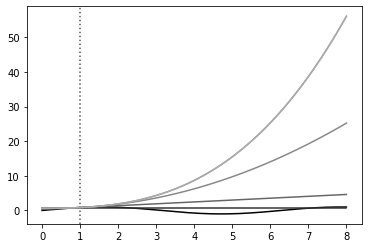

In [17]:
x = np.linspace(0,8,500)
taylor_plot(1, x)

We can see that our taylor approximations diverge a lot as we get further away from $a$; let's look a little bit closer:

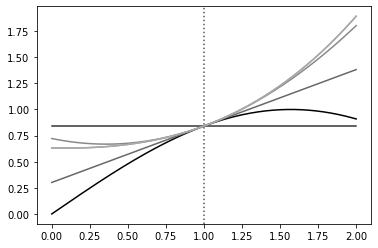

In [18]:
x = np.linspace(0, 2, 500)
taylor_plot(1, x)

So here, we notice a few things. First, that the 0th order taylor approximation isn't giving us much use; it's just the function output at the point $a$. Second, that as we get more terms, we achieve a diminishing return as far as how well the function actually gets approximated. The 2nd, 3rd, 4th order terms are all very close to the 1st order term as far as accuracy, in a region close enough to the pont. So let's look at just the first-order approximation:

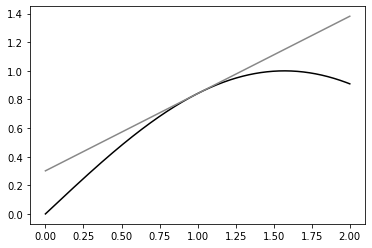

In [19]:
a = 1
# the actual function
y = np.sin(x)
# 1st order taylor approx.
y1 = np.sin(a) + np.cos(a) * (x - a)

plt.plot(x, y, 'k')
plt.plot(x, y1, '#888')

This is the power of the linear approximation. For a function $f(x)$, if we can find its derivative, we can produce a "pretty good" approximation for it around any area we want. Most importantly, that first-order approximation is a *linear* approximation. We notice our `y1` function above:

$$ \sin(a) + \cos(a) (x-a) $$ 

Has the same form as the familiar line equation: 

$$ c_1 + c_2 (x) $$

We can extend this line of thinking to the original pendulum system; the linearization method here works for *any* function, no matter how complex, so long as it is differentiable. It's a little bit of effort to take the derivative of the vector-valued system of ODEs we have above, so I'm only going to review it briefly here:

We represent the pendulum state as a vector: $\textbf{x} = [x, \dot{x}, \theta, \dot{\theta}]$. Here, bold $\textbf{x}$ represents the entire system, not just the cart position. With some rearranging, the original equations of motion can be written in terms of $\ddot{x}$ and $\ddot{\theta}$. The equations of motion can be written in vector form:

$$[\dot{x}, \ddot{x}, \dot{\theta}, \ddot{\theta}] = f([x, \dot{x}, \theta, \dot{\theta}]) $$

$$\dot{\textbf{x}} = f(\textbf{x})$$

In this form, the derivative of the function $f$ is the jacobian matrix of partial derivatives:

$$ \frac{\partial \textbf{x}}{\partial t} f(\textbf{x}) $$

So that the first-order taylor series approximation of the function is equal to 

$$ f_{linear}(x) = f(a) + \frac{\partial \textbf{x}}{\partial t} f(a) (x - a) $$

This approximation is often written in the canonical form.

$$ \dot{\textbf{x}} \approx A \textbf{x} + B \textbf{u} $$

So, now, we can take steps towards our goal. For a given state $\textbf{x} = a$, we want to find matrices $A$ and $B$ from this canonical form, by computing the partial derivative $\frac{\partial \textbf{x}}{\partial t} f(a)$ and rearranging the terms of the first-order taylor series approximation.

Which state will we linearize about?

In general, we choose the set point of the controller for the linearization. If our controller is any good, it will keep the state within the region surrounding the setpoint, and therefore, if it uses the linearization about that point to do so, it will have an accurate representation of the system state.

We choose $\textbf{a} = [0,0,0,0]$, which corresponds to the upright position.

After finding the derivative of our vector-valued function and rearranging some terms, we arrive at the linearized model of our original equation.

$$A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 &-\frac{m g}{M} & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & \frac{g m}{l} & 0 \\
\end{bmatrix} \qquad
B = \begin{bmatrix}
0 \\
\frac{1}{M} \\ 
0 \\
- \frac{1}{l M} \\
\end{bmatrix}$$

So how good is it? In order to see, we can write a simple "controller", that just measures parts of the state:

In [20]:
class Linearization_Measurement(controller.Controller):
    def __init__(self, pend, dt) -> None:
        self.pend = pend
        self.A, self.B = self.get_linear_sys(pend.jacA, pend.jacB, dt)
        self.x_1 = np.array([0,0,0.01,0])

    def policy(self, state: np.ndarray, dt: float):
        # get error from previous state
        self.err = state - self.x_1
        
        
        # predict next state
        self.x_1 = self.A @ state + self.B @ np.array([0])
        action = 0
        
        # store variables
        data = {}
        data.update(utils.array_to_kv("x_1", controller.LABELS, self.x_1))
        data.update(utils.array_to_kv("pred_err", controller.LABELS, self.err))
        return action, data

Now, let's set up a simulation to investigate:

In [21]:
dt, t_final = 0.01, 10
# start slightly tilted so that we get knocked over
pend = sim.Pendulum(2, 2, 2, initial_state=np.array([0,0,0.01,0]))
cont = Linearization_Measurement(pend, dt)
simu = sim.Simulation(dt, t_final, lambda t: 0)
results = simu.simulate(pend, cont)

100%|██████████| 1000/1000 [00:00<00:00, 2258.90it/s]


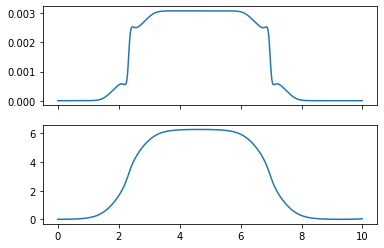

In [22]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(results[("pred_err", "t")].abs())
ax[1].plot(results[("state", "t")])

Now we can see pretty clearly that our approximation is good near the linearization point, and decreases as we move away from it. On top, we have the divergence of the linear model from the actual model, and on the bottom, we have the system state. Just like our taylor series for $\sin(x)$ above -- as we get further away from the linearization point, our 1st-order model becomes less accurate.